In [1]:
#install pytorch if you do not have installed
!pip install torch torchsummaryX --quiet

# Install skater to extract the features impacting in the train process
#!pip install skater 

# import time to visualize the total training time 
from time import time

# install libraries for computation of model: NumPy, Pandas, PyTorch, TorchsummaryX, Scikitlearn 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummaryX import summary
from sklearn.metrics import accuracy_score

# install libraries for utilities: gc, tqdm, os, datetime 
import gc
from tqdm.auto import tqdm
import os
import datetime

# install ETL
%cd /content/drive/MyDrive/Colab Notebooks/ECT/
from cervical_cancer import CervicalCancer
%cd /content/

#install confusion matrix for comparison to grand truth
from sklearn import metrics

# import skater to extract the features impacting in the train process
#from skater import Interpretation

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", device)

/content/drive/MyDrive/Colab Notebooks/ECT
/content
Device:  cpu


In [2]:
class BinaryBalancedSampler(DataLoader):
    def __init__(self, dataset, n_samples, balance = False):
        self.dataset = dataset
        self.balance = balance

        # separate dataset as inputs and targets 
        self.inputs = self.dataset[:, :-4]
        self.targets = self.dataset[:, -1].astype(np.int64)
        assert self.inputs.shape[0] == self.targets.shape[0]

        #inbalanced data identification
        target_counts = np.bincount(self.targets)
        major_target = target_counts.argmax()
        minor_target = target_counts.argmin()
        self.major_indices = np.where(self.targets == major_target)[0]
        self.minor_indices = np.where(self.targets == minor_target)[0]

        np.random.shuffle(self.major_indices)
        np.random.shuffle(self.minor_indices)

        # convert data as float
        for i in range(self.inputs.shape[1]):
            self.inputs[:, i] = self.inputs[:, i].astype(np.float32)
        #for i in range(self.inputs.shape[1]):
        #    print(f"self.inputs[0, i].dtype {type(self.inputs[0, i])}")

        # Set length of the dataset: 
        self.length = self.inputs.shape[0]

        # Debug:
        print(f"self.inputs {self.inputs.shape}")
        print(f"self.targets {self.targets.shape}")
        print(f"self.length {self.length}")

        self.used_indices = 0
        self.count = 0
        self.n_samples = n_samples
        #self.batch_size = self.n_samples * 2

        self.length = self.dataset.shape[0]

    def __len__(self):
      return self.length

    def __iter__(self):
        self.count = 0
        self.used_indices = int(0)
        if self.balance:
            while self.used_indices < len(self.major_indices):
                #print(f"self.used_indices {self.used_indices}")
                #print(f"self.major_indices {self.major_indices}")
                #batch_input = torch.tensor(np.array([input for input, target in batch], dtype=np.float32))
                #batch_target = torch.tensor(np.array([target for input, target in batch], dtype=np.int64))            
                indices = self.major_indices[self.used_indices:self.used_indices + self.n_samples].tolist()
                indices += np.random.choice(self.minor_indices, self.n_samples, replace=True).tolist()
                #print(f"indices {len(indices)}")
                inputs_tensor = torch.tensor(self.inputs[indices].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[indices].astype(np.int64))
                #print(f"inputs_tensor {inputs_tensor.shape}")
                #print(f"targets_tensor {targets_tensor.shape}")
                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2
        else:
            while self.used_indices < self.targets.shape[0]:
                inputs_tensor = torch.tensor(self.inputs[self.used_indices: self.used_indices + self.n_samples].astype(np.float32))
                targets_tensor = torch.tensor(self.targets[self.used_indices: self.used_indices + self.n_samples].astype(np.int64))
                
                yield inputs_tensor, targets_tensor
                
                self.used_indices += self.n_samples
                self.count += self.n_samples * 2

# Debug
cc_array = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='array')
test_iter = BinaryBalancedSampler(cc_array.dataset, n_samples=40, balance=False)
for i in test_iter:
    inputs, targets = i
    print(inputs.shape)
    print(targets.shape)
    print(np.bincount(targets))
    break

#if __name__ == '__main__':
#    cc_array = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='array')
#    dataset = Dataset(cc_array.dataset)

self.inputs (858, 32)
self.targets (858,)
self.length 858
torch.Size([40, 32])
torch.Size([40])
[37  3]


In [3]:
cc_df = CervicalCancer(data_path='/content/', file='risk_factors_cervical_cancer.csv', mode='dataframe')
# shuffle data
indices = np.random.permutation(np.arange(cc_array.dataset.shape[0]))
shaffled_dataset = []
for i in indices:
    shaffled_dataset.append(cc_array.dataset[i])
shaffled_dataset = np.array(shaffled_dataset)
#print(f"sheffled_dataset {sheffled_dataset.shape}")

train_dataset_ratio = 0.8
train_dataset_length = int(shaffled_dataset.shape[0] * train_dataset_ratio)
train_dataset = shaffled_dataset[:train_dataset_length].astype(np.float32)
test_dataset = shaffled_dataset[train_dataset_length:].astype(np.float32)
#print(f"train_dataset_length {train_dataset_length}")
#print(f"train_dataset {train_dataset.shape}")
#print(f"test_dataset {test_dataset.shape}")

In [4]:
configs = {
    'epochs': 1000,
    'batch_size' : 32,
    'learning_rate' : 0.01,
    'weight_decay' : 0,
    'dropout_value' : 0.55,
    'T_max':30,
    'eta_min':0,
    'n_samples':50,
}

In [5]:
# Dataloaders will yield a batch of frames and phonemes of given batch_size at every iteration
train_loader = BinaryBalancedSampler(train_dataset, n_samples=configs['n_samples'], balance=True)

test_loader = BinaryBalancedSampler(test_dataset, n_samples=10, balance=False)

self.inputs (686, 32)
self.targets (686,)
self.length 686
self.inputs (172, 32)
self.targets (172,)
self.length 172


In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.model = nn.Sequential(
            # first layer: lowest layer faeture values and activation
            nn.Linear(32, 64, device=device),
            nn.BatchNorm1d(64, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 1: hidden faeture values
            nn.Linear(64, 128, device=device),
            nn.BatchNorm1d(128, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 2: hidden faeture values
            nn.Linear(128, 256, device=device),
            nn.BatchNorm1d(256, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 3: hidden faeture values
            nn.Linear(256, 128, device=device),
            nn.BatchNorm1d(128, device=device),
            nn.ReLU(inplace=True),
            nn.Dropout(configs['dropout_value']),

            # hidden layer 4: hidden faeture values
            #nn.Linear(128, 64, device=device),
            #nn.BatchNorm1d(64, device=device),
            #nn.ReLU(inplace=True),

            # output layer: classification result
            nn.Linear(128, 2, device=device),
        )
        
        # initialization the model weights and model bias
        self.apply(self._init_weights)
       
    def forward(self, x):
        x = x.to(device)
        output = self.model(x).to(device)
        #print(f"output {output.shape} {output.dtype} {output}")
        return output

    # Weight and Bias initialization: Kaiming/Xavier
    # Code from Pytorch (https://pytorch.org/docs/stable/nn.init.html)
    # Code from WandB (https://stackoverflow.com/questions/49433936/how-do-i-initialize-weights-in-pytorch)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')


In [7]:
# If you execute model for the first time, use this command
model = NeuralNetwork().to(device)
inputs, targets = next(iter(train_loader))
summary(model, inputs)

                        Kernel Shape Output Shape   Params Mult-Adds
Layer                                                               
0_model.Linear_0            [32, 64]    [100, 64]   2.112k    2.048k
1_model.BatchNorm1d_1           [64]    [100, 64]    128.0      64.0
2_model.ReLU_2                     -    [100, 64]        -         -
3_model.Dropout_3                  -    [100, 64]        -         -
4_model.Linear_4           [64, 128]   [100, 128]    8.32k    8.192k
5_model.BatchNorm1d_5          [128]   [100, 128]    256.0     128.0
6_model.ReLU_6                     -   [100, 128]        -         -
7_model.Dropout_7                  -   [100, 128]        -         -
8_model.Linear_8          [128, 256]   [100, 256]  33.024k   32.768k
9_model.BatchNorm1d_9          [256]   [100, 256]    512.0     256.0
10_model.ReLU_10                   -   [100, 256]        -         -
11_model.Dropout_11                -   [100, 256]        -         -
12_model.Linear_12        [256, 12

/usr/local/lib/python3.7/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Linear_0,"[32, 64]","[100, 64]",2112.0,2048.0
1_model.BatchNorm1d_1,[64],"[100, 64]",128.0,64.0
2_model.ReLU_2,-,"[100, 64]",NaN,NaN
3_model.Dropout_3,-,"[100, 64]",NaN,NaN
4_model.Linear_4,"[64, 128]","[100, 128]",8320.0,8192.0
5_model.BatchNorm1d_5,[128],"[100, 128]",256.0,128.0
6_model.ReLU_6,-,"[100, 128]",NaN,NaN
7_model.Dropout_7,-,"[100, 128]",NaN,NaN
8_model.Linear_8,"[128, 256]","[100, 256]",33024.0,32768.0


In [8]:
# Criterion, Optimizer and Scheduler
criterion = nn.CrossEntropyLoss()
criterion.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=configs['learning_rate'])
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=configs['T_max'], eta_min=configs['eta_min'])

In [9]:
def train(model, optimizer, scheduler, criterion, dataloader):
    model.train()
    train_loss = 0.0 #Monitoring Loss
    
    for iter, (inputs, targets) in enumerate(dataloader):
        num_batch = iter
        inputs = inputs.to(device)
        targets = targets.to(device)

        prediction_list = []
        true_list = []

        #print(f"inputs {inputs.shape} {inputs.dtype} {inputs}")
        #print(f"targets {targets.shape} {targets.dtype} {targets}")
        ### Loss Calculation
        with torch.cuda.amp.autocast():
            ### Forward Propagation
            logits = model(inputs)
            loss = criterion(logits, targets)
            ### Get Predictions
            prediction = torch.argmax(logits, dim=1)
            
            train_loss = train_loss +  loss.item()

        ### Store Pred and True Labels
        prediction_list.extend(np.array(prediction.cpu().tolist()))
        true_list.extend(np.array(targets.cpu().tolist()))

        ### Initialize Gradients
        optimizer.zero_grad()
        ### Backward Propagation
        loss.backward()
        ### Gradient Descent
        optimizer.step()

    ### Schedule update
    scheduler.step()
  
    train_loss /= num_batch
    return train_loss, prediction_list, true_list

In [10]:
def eval(model, dataloader):
    model.eval() # set model in evaluation mode

    prediction_list = []
    true_list = []

    for iter, (inputs, targets) in enumerate(dataloader):
        
        inputs = inputs.to(device)
        targets = targets.to(device)

        ### Loss Calculation
        with torch.cuda.amp.autocast():
            ### Forward Propagation
            logits = model(inputs)
            loss = criterion(logits, targets)
            test_loss = train_loss + loss.item()
            ### Get Predictions
            prediction = torch.argmax(logits, dim=1)
        
        ### Store Pred and True Labels
        prediction_list.extend(np.array(prediction.cpu().tolist()))
        true_list.extend(np.array(targets.cpu().tolist()))
        
        #del frames, phonemes, logits, loss
        torch.cuda.empty_cache()

    ### Calculate Accuracy
    accuracy = accuracy_score(prediction_list, true_list) 
    return accuracy*100, prediction_list, true_list

In [11]:
# Iterate over number of epochs to train and evaluate your model
torch.cuda.empty_cache()

best_acc = 0.0 ### Monitor best accuracy in your run
start = time()

for epoch in range(configs['epochs']):
    print("\nEpoch {}/{}".format(epoch+1, configs['epochs']))
    train_loss, train_prediction_list, train_true_list  = train(model, optimizer, scheduler, criterion, train_loader)
    accuracy, test_prediction_list, test_true_list = eval(model, test_loader)

    print("\tTrain Loss: {:.4f}".format(train_loss))
    print("\tValidation Accuracy: {:.2f}%".format(accuracy))
    # Debug:
    # print(f"\tprediction_list {prediction_list}")
    # print(f"\ttrue_list \t{true_list}")



Epoch 1/1000
	Train Loss: 5.0820
	Validation Accuracy: 61.63%

Epoch 2/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 3.1166
	Validation Accuracy: 59.30%

Epoch 3/1000
	Train Loss: 2.6944

/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')



	Validation Accuracy: 40.12%

Epoch 4/1000
	Train Loss: 2.0727
	Validation Accuracy: 61.05%

Epoch 5/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.7973
	Validation Accuracy: 86.05%

Epoch 6/1000
	Train Loss: 1.7349
	Validation Accuracy: 83.72%

Epoch 7/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.4753
	Validation Accuracy: 84.88%

Epoch 8/1000
	Train Loss: 1.4181
	Validation Accuracy: 84.88%

Epoch 9/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.3766
	Validation Accuracy: 84.30%

Epoch 10/1000
	Train Loss: 1.2179
	Validation Accuracy: 83.72%

Epoch 11/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.2745
	Validation Accuracy: 79.65%

Epoch 12/1000
	Train Loss: 1.0750
	Validation Accuracy: 84.30%

Epoch 13/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.1440
	Validation Accuracy: 84.30%

Epoch 14/1000
	Train Loss: 1.0525
	Validation Accuracy: 83.72%

Epoch 15/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9807
	Validation Accuracy: 84.30%

Epoch 16/1000
	Train Loss: 0.9763
	Validation Accuracy: 81.98%

Epoch 17/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8850
	Validation Accuracy: 83.14%

Epoch 18/1000
	Train Loss: 0.9833
	Validation Accuracy: 84.88%

Epoch 19/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.0451
	Validation Accuracy: 79.65%

Epoch 20/1000
	Train Loss: 1.0383
	Validation Accuracy: 78.49%

Epoch 21/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9961
	Validation Accuracy: 84.30%

Epoch 22/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9695
	Validation Accuracy: 83.72%

Epoch 23/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9739
	Validation Accuracy: 83.72%

Epoch 24/1000
	Train Loss: 1.0026
	Validation Accuracy: 83.72%

Epoch 25/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.0516
	Validation Accuracy: 83.72%

Epoch 26/1000
	Train Loss: 0.8952
	Validation Accuracy: 83.72%

Epoch 27/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.1497
	Validation Accuracy: 84.30%

Epoch 28/1000
	Train Loss: 0.9377
	Validation Accuracy: 83.14%

Epoch 29/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9029
	Validation Accuracy: 82.56%

Epoch 30/1000
	Train Loss: 1.0161
	Validation Accuracy: 82.56%

Epoch 31/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.0763
	Validation Accuracy: 81.98%

Epoch 32/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.0003
	Validation Accuracy: 81.98%

Epoch 33/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9183
	Validation Accuracy: 82.56%

Epoch 34/1000
	Train Loss: 0.9140
	Validation Accuracy: 82.56%

Epoch 35/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 1.0704
	Validation Accuracy: 84.30%

Epoch 36/1000
	Train Loss: 1.0145
	Validation Accuracy: 83.14%

Epoch 37/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9303
	Validation Accuracy: 83.14%

Epoch 38/1000
	Train Loss: 0.9273
	Validation Accuracy: 83.14%

Epoch 39/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9610
	Validation Accuracy: 82.56%

Epoch 40/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8667
	Validation Accuracy: 83.14%

Epoch 41/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9184
	Validation Accuracy: 83.14%

Epoch 42/1000
	Train Loss: 0.9534
	Validation Accuracy: 82.56%

Epoch 43/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8744
	Validation Accuracy: 80.81%

Epoch 44/1000
	Train Loss: 0.8648
	Validation Accuracy: 81.98%

Epoch 45/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9149
	Validation Accuracy: 83.14%

Epoch 46/1000
	Train Loss: 0.9435
	Validation Accuracy: 82.56%

Epoch 47/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.9344
	Validation Accuracy: 82.56%

Epoch 48/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8260
	Validation Accuracy: 82.56%

Epoch 49/1000
	Train Loss: 0.8598
	Validation Accuracy: 83.14%

Epoch 50/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8689
	Validation Accuracy: 81.40%

Epoch 51/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8241
	Validation Accuracy: 78.49%

Epoch 52/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.8276
	Validation Accuracy: 82.56%

Epoch 53/1000
	Train Loss: 0.7836
	Validation Accuracy: 77.33%

Epoch 54/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.7671
	Validation Accuracy: 73.26%

Epoch 55/1000
	Train Loss: 0.8334
	Validation Accuracy: 79.07%

Epoch 56/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.7852
	Validation Accuracy: 76.74%

Epoch 57/1000
	Train Loss: 0.7814
	Validation Accuracy: 77.91%

Epoch 58/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.7370
	Validation Accuracy: 77.33%

Epoch 59/1000
	Train Loss: 0.7795
	Validation Accuracy: 66.86%

Epoch 60/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.7617
	Validation Accuracy: 70.35%

Epoch 61/1000
	Train Loss: 0.7313
	Validation Accuracy: 76.74%

Epoch 62/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6847
	Validation Accuracy: 63.37%

Epoch 63/1000
	Train Loss: 0.6793
	Validation Accuracy: 75.58%

Epoch 64/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.7130
	Validation Accuracy: 72.09%

Epoch 65/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6638
	Validation Accuracy: 73.84%

Epoch 66/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6690
	Validation Accuracy: 74.42%

Epoch 67/1000
	Train Loss: 0.6510
	Validation Accuracy: 71.51%

Epoch 68/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6404
	Validation Accuracy: 67.44%

Epoch 69/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6340
	Validation Accuracy: 76.74%

Epoch 70/1000
	Train Loss: 0.6446
	Validation Accuracy: 70.35%

Epoch 71/1000
	Train Loss: 0.6259
	Validation Accuracy: 72.67%

Epoch 72/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6012
	Validation Accuracy: 74.42%

Epoch 73/1000
	Train Loss: 0.6398
	Validation Accuracy: 73.84%

Epoch 74/1000
	Train Loss: 0.6005
	Validation Accuracy: 76.16%

Epoch 75/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6511
	Validation Accuracy: 74.42%

Epoch 76/1000
	Train Loss: 0.6058
	Validation Accuracy: 70.93%

Epoch 77/1000
	Train Loss: 0.6043
	Validation Accuracy: 74.42%

Epoch 78/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5719
	Validation Accuracy: 76.16%

Epoch 79/1000
	Train Loss: 0.6160
	Validation Accuracy: 75.58%

Epoch 80/1000
	Train Loss: 0.6089
	Validation Accuracy: 70.35%

Epoch 81/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5700
	Validation Accuracy: 68.60%

Epoch 82/1000
	Train Loss: 0.6051
	Validation Accuracy: 70.93%

Epoch 83/1000
	Train Loss: 0.5396
	Validation Accuracy: 76.16%

Epoch 84/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.6024
	Validation Accuracy: 73.26%

Epoch 85/1000
	Train Loss: 0.5882
	Validation Accuracy: 73.26%

Epoch 86/1000
	Train Loss: 0.5764
	Validation Accuracy: 73.84%

Epoch 87/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5579
	Validation Accuracy: 73.26%

Epoch 88/1000
	Train Loss: 0.5997
	Validation Accuracy: 73.84%

Epoch 89/1000
	Train Loss: 0.6067
	Validation Accuracy: 70.93%

Epoch 90/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5707
	Validation Accuracy: 72.67%

Epoch 91/1000
	Train Loss: 0.5374
	Validation Accuracy: 73.84%

Epoch 92/1000
	Train Loss: 0.5624
	Validation Accuracy: 73.84%

Epoch 93/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5897
	Validation Accuracy: 73.26%

Epoch 94/1000
	Train Loss: 0.5723
	Validation Accuracy: 73.84%

Epoch 95/1000
	Train Loss: 0.5711
	Validation Accuracy: 73.84%

Epoch 96/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5769
	Validation Accuracy: 74.42%

Epoch 97/1000
	Train Loss: 0.6047
	Validation Accuracy: 73.26%

Epoch 98/1000
	Train Loss: 0.5680
	Validation Accuracy: 73.26%

Epoch 99/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5678
	Validation Accuracy: 75.00%

Epoch 100/1000
	Train Loss: 0.5588
	Validation Accuracy: 73.26%

Epoch 101/1000
	Train Loss: 0.5509
	Validation Accuracy: 79.07%

Epoch 102/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5258
	Validation Accuracy: 74.42%

Epoch 103/1000
	Train Loss: 0.5508
	Validation Accuracy: 78.49%

Epoch 104/1000
	Train Loss: 0.5424
	Validation Accuracy: 76.16%

Epoch 105/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5759
	Validation Accuracy: 73.26%

Epoch 106/1000
	Train Loss: 0.5555
	Validation Accuracy: 79.07%

Epoch 107/1000
	Train Loss: 0.5479
	Validation Accuracy: 72.67%

Epoch 108/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5440
	Validation Accuracy: 75.00%

Epoch 109/1000
	Train Loss: 0.5546
	Validation Accuracy: 81.40%

Epoch 110/1000
	Train Loss: 0.5433
	Validation Accuracy: 68.02%

Epoch 111/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5294
	Validation Accuracy: 75.58%

Epoch 112/1000
	Train Loss: 0.5286
	Validation Accuracy: 78.49%

Epoch 113/1000
	Train Loss: 0.5495
	Validation Accuracy: 76.74%

Epoch 114/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5152
	Validation Accuracy: 86.63%

Epoch 115/1000
	Train Loss: 0.5200
	Validation Accuracy: 76.16%

Epoch 116/1000
	Train Loss: 0.5205
	Validation Accuracy: 76.74%

Epoch 117/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.5359
	Validation Accuracy: 83.14%

Epoch 118/1000
	Train Loss: 0.5070
	Validation Accuracy: 66.28%

Epoch 119/1000
	Train Loss: 0.5083
	Validation Accuracy: 79.07%

Epoch 120/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4754
	Validation Accuracy: 86.63%

Epoch 121/1000
	Train Loss: 0.5096
	Validation Accuracy: 81.40%

Epoch 122/1000
	Train Loss: 0.4866
	Validation Accuracy: 82.56%

Epoch 123/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4774
	Validation Accuracy: 76.16%

Epoch 124/1000
	Train Loss: 0.4751
	Validation Accuracy: 73.84%

Epoch 125/1000
	Train Loss: 0.4837
	Validation Accuracy: 78.49%

Epoch 126/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4788
	Validation Accuracy: 79.65%

Epoch 127/1000
	Train Loss: 0.4979
	Validation Accuracy: 76.16%

Epoch 128/1000
	Train Loss: 0.4914
	Validation Accuracy: 83.14%

Epoch 129/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4715
	Validation Accuracy: 79.65%

Epoch 130/1000
	Train Loss: 0.4717
	Validation Accuracy: 68.02%

Epoch 131/1000
	Train Loss: 0.4369
	Validation Accuracy: 73.84%

Epoch 132/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4582
	Validation Accuracy: 84.88%

Epoch 133/1000
	Train Loss: 0.4654
	Validation Accuracy: 81.98%

Epoch 134/1000
	Train Loss: 0.4421
	Validation Accuracy: 77.33%

Epoch 135/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4221
	Validation Accuracy: 80.23%

Epoch 136/1000
	Train Loss: 0.4192
	Validation Accuracy: 80.23%

Epoch 137/1000
	Train Loss: 0.4521
	Validation Accuracy: 76.74%

Epoch 138/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3952
	Validation Accuracy: 79.65%

Epoch 139/1000
	Train Loss: 0.4283
	Validation Accuracy: 84.88%

Epoch 140/1000
	Train Loss: 0.3945
	Validation Accuracy: 78.49%

Epoch 141/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4105
	Validation Accuracy: 77.33%

Epoch 142/1000
	Train Loss: 0.3984
	Validation Accuracy: 80.81%

Epoch 143/1000
	Train Loss: 0.4069
	Validation Accuracy: 80.81%

Epoch 144/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4006
	Validation Accuracy: 79.07%

Epoch 145/1000
	Train Loss: 0.3752
	Validation Accuracy: 81.40%

Epoch 146/1000
	Train Loss: 0.4033
	Validation Accuracy: 80.23%

Epoch 147/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3941
	Validation Accuracy: 80.23%

Epoch 148/1000
	Train Loss: 0.4018
	Validation Accuracy: 77.91%

Epoch 149/1000
	Train Loss: 0.3910
	Validation Accuracy: 77.33%

Epoch 150/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3946
	Validation Accuracy: 79.65%

Epoch 151/1000
	Train Loss: 0.3737
	Validation Accuracy: 78.49%

Epoch 152/1000
	Train Loss: 0.4109
	Validation Accuracy: 78.49%

Epoch 153/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3869
	Validation Accuracy: 79.07%

Epoch 154/1000
	Train Loss: 0.3823
	Validation Accuracy: 78.49%

Epoch 155/1000
	Train Loss: 0.3800
	Validation Accuracy: 77.91%

Epoch 156/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3790
	Validation Accuracy: 79.07%

Epoch 157/1000
	Train Loss: 0.3627
	Validation Accuracy: 79.07%

Epoch 158/1000
	Train Loss: 0.4007
	Validation Accuracy: 80.81%

Epoch 159/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4001
	Validation Accuracy: 80.23%

Epoch 160/1000
	Train Loss: 0.4066
	Validation Accuracy: 78.49%

Epoch 161/1000
	Train Loss: 0.3854
	Validation Accuracy: 80.81%

Epoch 162/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3612
	Validation Accuracy: 80.23%

Epoch 163/1000
	Train Loss: 0.4037
	Validation Accuracy: 80.23%

Epoch 164/1000
	Train Loss: 0.3972
	Validation Accuracy: 75.58%

Epoch 165/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4036
	Validation Accuracy: 80.81%

Epoch 166/1000
	Train Loss: 0.3566
	Validation Accuracy: 79.07%

Epoch 167/1000
	Train Loss: 0.3733
	Validation Accuracy: 83.72%

Epoch 168/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3525
	Validation Accuracy: 79.07%

Epoch 169/1000
	Train Loss: 0.3550
	Validation Accuracy: 83.72%

Epoch 170/1000
	Train Loss: 0.3945
	Validation Accuracy: 73.26%

Epoch 171/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4090
	Validation Accuracy: 80.81%

Epoch 172/1000
	Train Loss: 0.4040
	Validation Accuracy: 80.23%

Epoch 173/1000
	Train Loss: 0.4136
	Validation Accuracy: 79.07%

Epoch 174/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.4175
	Validation Accuracy: 76.74%

Epoch 175/1000
	Train Loss: 0.4075
	Validation Accuracy: 84.30%

Epoch 176/1000
	Train Loss: 0.4051
	Validation Accuracy: 79.07%

Epoch 177/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3915
	Validation Accuracy: 79.07%

Epoch 178/1000
	Train Loss: 0.4004
	Validation Accuracy: 77.33%

Epoch 179/1000
	Train Loss: 0.3780
	Validation Accuracy: 81.40%

Epoch 180/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3907
	Validation Accuracy: 82.56%

Epoch 181/1000
	Train Loss: 0.4247
	Validation Accuracy: 81.40%

Epoch 182/1000
	Train Loss: 0.4093
	Validation Accuracy: 83.72%

Epoch 183/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3917
	Validation Accuracy: 81.98%

Epoch 184/1000
	Train Loss: 0.3900
	Validation Accuracy: 82.56%

Epoch 185/1000
	Train Loss: 0.3683
	Validation Accuracy: 79.07%

Epoch 186/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3622
	Validation Accuracy: 81.40%

Epoch 187/1000
	Train Loss: 0.3950
	Validation Accuracy: 81.40%

Epoch 188/1000
	Train Loss: 0.3817
	Validation Accuracy: 74.42%

Epoch 189/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3728
	Validation Accuracy: 80.23%

Epoch 190/1000
	Train Loss: 0.3784
	Validation Accuracy: 83.72%

Epoch 191/1000
	Train Loss: 0.3725
	Validation Accuracy: 76.74%

Epoch 192/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3441
	Validation Accuracy: 80.81%

Epoch 193/1000
	Train Loss: 0.3470
	Validation Accuracy: 79.65%

Epoch 194/1000
	Train Loss: 0.3642
	Validation Accuracy: 79.65%

Epoch 195/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3493
	Validation Accuracy: 78.49%

Epoch 196/1000
	Train Loss: 0.3497
	Validation Accuracy: 77.33%

Epoch 197/1000
	Train Loss: 0.3362
	Validation Accuracy: 80.23%

Epoch 198/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3400
	Validation Accuracy: 80.23%

Epoch 199/1000
	Train Loss: 0.3343
	Validation Accuracy: 81.40%

Epoch 200/1000
	Train Loss: 0.3297
	Validation Accuracy: 80.23%

Epoch 201/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3050
	Validation Accuracy: 80.23%

Epoch 202/1000
	Train Loss: 0.3264
	Validation Accuracy: 81.40%

Epoch 203/1000
	Train Loss: 0.3442
	Validation Accuracy: 82.56%

Epoch 204/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3385
	Validation Accuracy: 81.98%

Epoch 205/1000
	Train Loss: 0.3184
	Validation Accuracy: 78.49%

Epoch 206/1000
	Train Loss: 0.3003
	Validation Accuracy: 79.65%

Epoch 207/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3068
	Validation Accuracy: 80.23%

Epoch 208/1000
	Train Loss: 0.3167
	Validation Accuracy: 80.81%

Epoch 209/1000
	Train Loss: 0.3109
	Validation Accuracy: 80.23%

Epoch 210/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3190
	Validation Accuracy: 80.23%

Epoch 211/1000
	Train Loss: 0.3520
	Validation Accuracy: 79.65%

Epoch 212/1000
	Train Loss: 0.2997
	Validation Accuracy: 79.07%

Epoch 213/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3073
	Validation Accuracy: 79.07%

Epoch 214/1000
	Train Loss: 0.2876
	Validation Accuracy: 79.65%

Epoch 215/1000
	Train Loss: 0.3178
	Validation Accuracy: 79.65%

Epoch 216/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3006
	Validation Accuracy: 80.81%

Epoch 217/1000
	Train Loss: 0.3285
	Validation Accuracy: 79.65%

Epoch 218/1000
	Train Loss: 0.3483
	Validation Accuracy: 79.65%

Epoch 219/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3046
	Validation Accuracy: 81.98%

Epoch 220/1000
	Train Loss: 0.3229
	Validation Accuracy: 81.40%

Epoch 221/1000
	Train Loss: 0.3041
	Validation Accuracy: 80.81%

Epoch 222/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3163
	Validation Accuracy: 82.56%

Epoch 223/1000
	Train Loss: 0.2908
	Validation Accuracy: 78.49%

Epoch 224/1000
	Train Loss: 0.3214
	Validation Accuracy: 78.49%

Epoch 225/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3003
	Validation Accuracy: 81.40%

Epoch 226/1000
	Train Loss: 0.2966
	Validation Accuracy: 80.23%

Epoch 227/1000
	Train Loss: 0.3186
	Validation Accuracy: 76.74%

Epoch 228/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3373
	Validation Accuracy: 79.65%

Epoch 229/1000
	Train Loss: 0.2979
	Validation Accuracy: 82.56%

Epoch 230/1000
	Train Loss: 0.3415
	Validation Accuracy: 84.30%

Epoch 231/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3438
	Validation Accuracy: 77.33%

Epoch 232/1000
	Train Loss: 0.3217
	Validation Accuracy: 80.23%

Epoch 233/1000
	Train Loss: 0.3249
	Validation Accuracy: 86.63%

Epoch 234/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3354
	Validation Accuracy: 83.72%

Epoch 235/1000
	Train Loss: 0.3213
	Validation Accuracy: 87.21%

Epoch 236/1000
	Train Loss: 0.3353
	Validation Accuracy: 84.30%

Epoch 237/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3859
	Validation Accuracy: 69.19%

Epoch 238/1000
	Train Loss: 0.3607
	Validation Accuracy: 77.33%

Epoch 239/1000
	Train Loss: 0.3222
	Validation Accuracy: 77.91%

Epoch 240/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3481
	Validation Accuracy: 82.56%

Epoch 241/1000
	Train Loss: 0.3320
	Validation Accuracy: 83.72%

Epoch 242/1000
	Train Loss: 0.3424
	Validation Accuracy: 81.40%

Epoch 243/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3820
	Validation Accuracy: 80.81%

Epoch 244/1000
	Train Loss: 0.3433
	Validation Accuracy: 81.40%

Epoch 245/1000
	Train Loss: 0.3261
	Validation Accuracy: 83.72%

Epoch 246/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2993
	Validation Accuracy: 86.63%

Epoch 247/1000
	Train Loss: 0.3291
	Validation Accuracy: 84.30%

Epoch 248/1000
	Train Loss: 0.3260
	Validation Accuracy: 81.98%

Epoch 249/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3292
	Validation Accuracy: 79.07%

Epoch 250/1000
	Train Loss: 0.3153
	Validation Accuracy: 82.56%

Epoch 251/1000
	Train Loss: 0.2982
	Validation Accuracy: 81.40%

Epoch 252/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3109
	Validation Accuracy: 80.81%

Epoch 253/1000
	Train Loss: 0.3259
	Validation Accuracy: 84.30%

Epoch 254/1000
	Train Loss: 0.2866
	Validation Accuracy: 80.81%

Epoch 255/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2783
	Validation Accuracy: 81.98%

Epoch 256/1000
	Train Loss: 0.2800
	Validation Accuracy: 80.81%

Epoch 257/1000
	Train Loss: 0.2966
	Validation Accuracy: 78.49%

Epoch 258/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2977
	Validation Accuracy: 81.40%

Epoch 259/1000
	Train Loss: 0.2915
	Validation Accuracy: 81.98%

Epoch 260/1000
	Train Loss: 0.2963
	Validation Accuracy: 81.98%

Epoch 261/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2742
	Validation Accuracy: 79.65%

Epoch 262/1000
	Train Loss: 0.2863
	Validation Accuracy: 81.40%

Epoch 263/1000
	Train Loss: 0.2836
	Validation Accuracy: 80.23%

Epoch 264/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2846
	Validation Accuracy: 81.40%

Epoch 265/1000
	Train Loss: 0.2853
	Validation Accuracy: 80.81%

Epoch 266/1000
	Train Loss: 0.2973
	Validation Accuracy: 80.23%

Epoch 267/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2739
	Validation Accuracy: 80.23%

Epoch 268/1000
	Train Loss: 0.2790
	Validation Accuracy: 80.81%

Epoch 269/1000
	Train Loss: 0.2757
	Validation Accuracy: 79.65%

Epoch 270/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2816
	Validation Accuracy: 79.65%

Epoch 271/1000
	Train Loss: 0.2812
	Validation Accuracy: 80.81%

Epoch 272/1000
	Train Loss: 0.2634
	Validation Accuracy: 80.81%

Epoch 273/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2526
	Validation Accuracy: 80.23%

Epoch 274/1000
	Train Loss: 0.2753
	Validation Accuracy: 80.23%

Epoch 275/1000
	Train Loss: 0.2576
	Validation Accuracy: 79.65%

Epoch 276/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2581
	Validation Accuracy: 80.81%

Epoch 277/1000
	Train Loss: 0.2654
	Validation Accuracy: 81.40%

Epoch 278/1000
	Train Loss: 0.2740
	Validation Accuracy: 80.81%

Epoch 279/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2680
	Validation Accuracy: 81.98%

Epoch 280/1000
	Train Loss: 0.2756
	Validation Accuracy: 81.98%

Epoch 281/1000
	Train Loss: 0.2477
	Validation Accuracy: 80.23%

Epoch 282/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2888
	Validation Accuracy: 82.56%

Epoch 283/1000
	Train Loss: 0.2796
	Validation Accuracy: 79.65%

Epoch 284/1000
	Train Loss: 0.2825
	Validation Accuracy: 77.91%

Epoch 285/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2889
	Validation Accuracy: 81.98%

Epoch 286/1000
	Train Loss: 0.2843
	Validation Accuracy: 84.88%

Epoch 287/1000
	Train Loss: 0.2674
	Validation Accuracy: 80.81%

Epoch 288/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2521
	Validation Accuracy: 84.88%

Epoch 289/1000
	Train Loss: 0.2700
	Validation Accuracy: 86.05%

Epoch 290/1000
	Train Loss: 0.3148
	Validation Accuracy: 82.56%

Epoch 291/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2936
	Validation Accuracy: 80.81%

Epoch 292/1000
	Train Loss: 0.3179
	Validation Accuracy: 81.40%

Epoch 293/1000
	Train Loss: 0.2850
	Validation Accuracy: 82.56%

Epoch 294/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2841
	Validation Accuracy: 83.72%

Epoch 295/1000
	Train Loss: 0.3186
	Validation Accuracy: 77.91%

Epoch 296/1000
	Train Loss: 0.2959
	Validation Accuracy: 84.30%

Epoch 297/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3441
	Validation Accuracy: 79.07%

Epoch 298/1000
	Train Loss: 0.3211
	Validation Accuracy: 82.56%

Epoch 299/1000
	Train Loss: 0.3031
	Validation Accuracy: 77.91%

Epoch 300/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3052
	Validation Accuracy: 85.47%

Epoch 301/1000
	Train Loss: 0.3318
	Validation Accuracy: 81.98%

Epoch 302/1000
	Train Loss: 0.2928
	Validation Accuracy: 80.23%

Epoch 303/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2890
	Validation Accuracy: 79.07%

Epoch 304/1000
	Train Loss: 0.2797
	Validation Accuracy: 81.40%

Epoch 305/1000
	Train Loss: 0.2823
	Validation Accuracy: 81.98%

Epoch 306/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3250
	Validation Accuracy: 80.23%

Epoch 307/1000
	Train Loss: 0.2994
	Validation Accuracy: 79.07%

Epoch 308/1000
	Train Loss: 0.2947
	Validation Accuracy: 76.74%

Epoch 309/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2935
	Validation Accuracy: 83.72%

Epoch 310/1000
	Train Loss: 0.2818
	Validation Accuracy: 84.88%

Epoch 311/1000
	Train Loss: 0.3000
	Validation Accuracy: 81.40%

Epoch 312/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2896
	Validation Accuracy: 83.14%

Epoch 313/1000
	Train Loss: 0.2712
	Validation Accuracy: 83.72%

Epoch 314/1000
	Train Loss: 0.2851
	Validation Accuracy: 83.72%

Epoch 315/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2581
	Validation Accuracy: 81.98%

Epoch 316/1000
	Train Loss: 0.2539
	Validation Accuracy: 80.81%

Epoch 317/1000
	Train Loss: 0.2779
	Validation Accuracy: 80.81%

Epoch 318/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2888
	Validation Accuracy: 83.14%

Epoch 319/1000
	Train Loss: 0.2737
	Validation Accuracy: 81.98%

Epoch 320/1000
	Train Loss: 0.2501
	Validation Accuracy: 81.40%

Epoch 321/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2700
	Validation Accuracy: 81.98%

Epoch 322/1000
	Train Loss: 0.2387
	Validation Accuracy: 83.72%

Epoch 323/1000
	Train Loss: 0.2282
	Validation Accuracy: 82.56%

Epoch 324/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2262
	Validation Accuracy: 81.40%

Epoch 325/1000
	Train Loss: 0.2594
	Validation Accuracy: 81.40%

Epoch 326/1000
	Train Loss: 0.2581
	Validation Accuracy: 81.98%

Epoch 327/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2437
	Validation Accuracy: 81.98%

Epoch 328/1000
	Train Loss: 0.2914
	Validation Accuracy: 81.98%

Epoch 329/1000
	Train Loss: 0.2539
	Validation Accuracy: 81.40%

Epoch 330/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2650
	Validation Accuracy: 82.56%

Epoch 331/1000
	Train Loss: 0.2452
	Validation Accuracy: 81.40%

Epoch 332/1000
	Train Loss: 0.2591
	Validation Accuracy: 80.81%

Epoch 333/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2632
	Validation Accuracy: 82.56%

Epoch 334/1000
	Train Loss: 0.2412
	Validation Accuracy: 82.56%

Epoch 335/1000
	Train Loss: 0.2419
	Validation Accuracy: 82.56%

Epoch 336/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2417
	Validation Accuracy: 81.98%

Epoch 337/1000
	Train Loss: 0.2407
	Validation Accuracy: 81.40%

Epoch 338/1000
	Train Loss: 0.2399
	Validation Accuracy: 81.98%

Epoch 339/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2727
	Validation Accuracy: 81.98%

Epoch 340/1000
	Train Loss: 0.2795
	Validation Accuracy: 81.98%

Epoch 341/1000
	Train Loss: 0.2616
	Validation Accuracy: 83.14%

Epoch 342/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2305
	Validation Accuracy: 81.40%

Epoch 343/1000
	Train Loss: 0.2828
	Validation Accuracy: 82.56%

Epoch 344/1000
	Train Loss: 0.2384
	Validation Accuracy: 83.14%

Epoch 345/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2375
	Validation Accuracy: 84.88%

Epoch 346/1000
	Train Loss: 0.2556
	Validation Accuracy: 81.40%

Epoch 347/1000
	Train Loss: 0.2742
	Validation Accuracy: 83.14%

Epoch 348/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2584
	Validation Accuracy: 83.72%

Epoch 349/1000
	Train Loss: 0.2837
	Validation Accuracy: 83.14%

Epoch 350/1000
	Train Loss: 0.2782
	Validation Accuracy: 81.98%

Epoch 351/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2659
	Validation Accuracy: 84.30%

Epoch 352/1000
	Train Loss: 0.2711
	Validation Accuracy: 84.88%

Epoch 353/1000
	Train Loss: 0.2771
	Validation Accuracy: 80.81%

Epoch 354/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2683
	Validation Accuracy: 84.30%

Epoch 355/1000
	Train Loss: 0.2841
	Validation Accuracy: 84.30%

Epoch 356/1000
	Train Loss: 0.2990
	Validation Accuracy: 81.40%

Epoch 357/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.3418
	Validation Accuracy: 81.40%

Epoch 358/1000
	Train Loss: 0.2669
	Validation Accuracy: 83.72%

Epoch 359/1000
	Train Loss: 0.2909
	Validation Accuracy: 81.98%

Epoch 360/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2760
	Validation Accuracy: 80.23%

Epoch 361/1000
	Train Loss: 0.2949
	Validation Accuracy: 81.98%

Epoch 362/1000
	Train Loss: 0.2894
	Validation Accuracy: 83.14%

Epoch 363/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2697
	Validation Accuracy: 81.40%

Epoch 364/1000
	Train Loss: 0.2904
	Validation Accuracy: 74.42%

Epoch 365/1000
	Train Loss: 0.3084
	Validation Accuracy: 86.05%

Epoch 366/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2691
	Validation Accuracy: 82.56%

Epoch 367/1000
	Train Loss: 0.3150
	Validation Accuracy: 80.81%

Epoch 368/1000
	Train Loss: 0.2932
	Validation Accuracy: 81.98%

Epoch 369/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2782
	Validation Accuracy: 84.88%

Epoch 370/1000
	Train Loss: 0.2678
	Validation Accuracy: 84.30%

Epoch 371/1000
	Train Loss: 0.2712
	Validation Accuracy: 82.56%

Epoch 372/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2734
	Validation Accuracy: 84.30%

Epoch 373/1000
	Train Loss: 0.2726
	Validation Accuracy: 81.98%

Epoch 374/1000
	Train Loss: 0.2797
	Validation Accuracy: 83.72%

Epoch 375/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2627
	Validation Accuracy: 81.98%

Epoch 376/1000
	Train Loss: 0.2547
	Validation Accuracy: 81.98%

Epoch 377/1000
	Train Loss: 0.2715
	Validation Accuracy: 80.81%

Epoch 378/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2297
	Validation Accuracy: 80.81%

Epoch 379/1000
	Train Loss: 0.2775
	Validation Accuracy: 81.98%

Epoch 380/1000
	Train Loss: 0.2669
	Validation Accuracy: 83.14%

Epoch 381/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2388
	Validation Accuracy: 81.98%

Epoch 382/1000
	Train Loss: 0.2492
	Validation Accuracy: 83.14%

Epoch 383/1000
	Train Loss: 0.2127
	Validation Accuracy: 82.56%

Epoch 384/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2169
	Validation Accuracy: 82.56%

Epoch 385/1000
	Train Loss: 0.2580
	Validation Accuracy: 82.56%

Epoch 386/1000
	Train Loss: 0.2425
	Validation Accuracy: 82.56%

Epoch 387/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2441
	Validation Accuracy: 82.56%

Epoch 388/1000
	Train Loss: 0.2524
	Validation Accuracy: 82.56%

Epoch 389/1000
	Train Loss: 0.2237
	Validation Accuracy: 82.56%

Epoch 390/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2226
	Validation Accuracy: 82.56%

Epoch 391/1000
	Train Loss: 0.2535
	Validation Accuracy: 83.14%

Epoch 392/1000
	Train Loss: 0.2543
	Validation Accuracy: 82.56%

Epoch 393/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2328
	Validation Accuracy: 82.56%

Epoch 394/1000
	Train Loss: 0.2580
	Validation Accuracy: 82.56%

Epoch 395/1000
	Train Loss: 0.2178
	Validation Accuracy: 82.56%

Epoch 396/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2342
	Validation Accuracy: 82.56%

Epoch 397/1000
	Train Loss: 0.2496
	Validation Accuracy: 83.14%

Epoch 398/1000
	Train Loss: 0.2224
	Validation Accuracy: 83.14%

Epoch 399/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2334
	Validation Accuracy: 83.14%

Epoch 400/1000
	Train Loss: 0.2554
	Validation Accuracy: 83.14%

Epoch 401/1000
	Train Loss: 0.2394
	Validation Accuracy: 83.14%

Epoch 402/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2542
	Validation Accuracy: 84.30%

Epoch 403/1000
	Train Loss: 0.2405
	Validation Accuracy: 81.98%

Epoch 404/1000
	Train Loss: 0.2218
	Validation Accuracy: 81.98%

Epoch 405/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1980
	Validation Accuracy: 83.14%

Epoch 406/1000
	Train Loss: 0.2271
	Validation Accuracy: 83.14%

Epoch 407/1000
	Train Loss: 0.2492
	Validation Accuracy: 83.14%

Epoch 408/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2487
	Validation Accuracy: 80.81%

Epoch 409/1000
	Train Loss: 0.2465
	Validation Accuracy: 81.98%

Epoch 410/1000
	Train Loss: 0.2743
	Validation Accuracy: 80.81%

Epoch 411/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2598
	Validation Accuracy: 81.98%

Epoch 412/1000
	Train Loss: 0.2753
	Validation Accuracy: 83.72%

Epoch 413/1000
	Train Loss: 0.2571
	Validation Accuracy: 81.40%

Epoch 414/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2728
	Validation Accuracy: 83.72%

Epoch 415/1000
	Train Loss: 0.2749
	Validation Accuracy: 81.40%

Epoch 416/1000
	Train Loss: 0.2583
	Validation Accuracy: 81.40%

Epoch 417/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2637
	Validation Accuracy: 81.40%

Epoch 418/1000
	Train Loss: 0.2650
	Validation Accuracy: 77.33%

Epoch 419/1000
	Train Loss: 0.2790
	Validation Accuracy: 83.14%

Epoch 420/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2796
	Validation Accuracy: 80.81%

Epoch 421/1000
	Train Loss: 0.2525
	Validation Accuracy: 83.72%

Epoch 422/1000
	Train Loss: 0.2691
	Validation Accuracy: 80.81%

Epoch 423/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2534
	Validation Accuracy: 83.14%

Epoch 424/1000
	Train Loss: 0.2856
	Validation Accuracy: 85.47%

Epoch 425/1000
	Train Loss: 0.2977
	Validation Accuracy: 77.33%

Epoch 426/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2770
	Validation Accuracy: 79.65%

Epoch 427/1000
	Train Loss: 0.2847
	Validation Accuracy: 83.14%

Epoch 428/1000
	Train Loss: 0.2681
	Validation Accuracy: 84.30%

Epoch 429/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2526
	Validation Accuracy: 83.14%

Epoch 430/1000
	Train Loss: 0.2661
	Validation Accuracy: 83.14%

Epoch 431/1000
	Train Loss: 0.2712
	Validation Accuracy: 83.14%

Epoch 432/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2831
	Validation Accuracy: 80.81%

Epoch 433/1000
	Train Loss: 0.2419
	Validation Accuracy: 81.98%

Epoch 434/1000
	Train Loss: 0.2678
	Validation Accuracy: 81.40%

Epoch 435/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2643
	Validation Accuracy: 81.98%

Epoch 436/1000
	Train Loss: 0.2538
	Validation Accuracy: 81.98%

Epoch 437/1000
	Train Loss: 0.2435
	Validation Accuracy: 81.40%

Epoch 438/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2314
	Validation Accuracy: 80.81%

Epoch 439/1000
	Train Loss: 0.2552
	Validation Accuracy: 82.56%

Epoch 440/1000
	Train Loss: 0.2562
	Validation Accuracy: 81.40%

Epoch 441/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2388
	Validation Accuracy: 82.56%

Epoch 442/1000
	Train Loss: 0.2634
	Validation Accuracy: 82.56%

Epoch 443/1000
	Train Loss: 0.2449
	Validation Accuracy: 81.98%

Epoch 444/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2295
	Validation Accuracy: 82.56%

Epoch 445/1000
	Train Loss: 0.2314
	Validation Accuracy: 81.98%

Epoch 446/1000
	Train Loss: 0.2122
	Validation Accuracy: 81.98%

Epoch 447/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2223
	Validation Accuracy: 82.56%

Epoch 448/1000
	Train Loss: 0.2166
	Validation Accuracy: 83.14%

Epoch 449/1000
	Train Loss: 0.2402
	Validation Accuracy: 82.56%

Epoch 450/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2248
	Validation Accuracy: 82.56%

Epoch 451/1000
	Train Loss: 0.2346
	Validation Accuracy: 82.56%

Epoch 452/1000
	Train Loss: 0.2386
	Validation Accuracy: 82.56%

Epoch 453/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2174
	Validation Accuracy: 83.14%

Epoch 454/1000
	Train Loss: 0.2447
	Validation Accuracy: 81.40%

Epoch 455/1000
	Train Loss: 0.2087
	Validation Accuracy: 82.56%

Epoch 456/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2164
	Validation Accuracy: 82.56%

Epoch 457/1000
	Train Loss: 0.2360
	Validation Accuracy: 83.72%

Epoch 458/1000
	Train Loss: 0.2268
	Validation Accuracy: 83.14%

Epoch 459/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2443
	Validation Accuracy: 81.98%

Epoch 460/1000
	Train Loss: 0.2131
	Validation Accuracy: 83.72%

Epoch 461/1000
	Train Loss: 0.2138
	Validation Accuracy: 83.14%

Epoch 462/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2309
	Validation Accuracy: 83.72%

Epoch 463/1000
	Train Loss: 0.2284
	Validation Accuracy: 83.72%

Epoch 464/1000
	Train Loss: 0.2356
	Validation Accuracy: 84.30%

Epoch 465/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2378
	Validation Accuracy: 84.88%

Epoch 466/1000
	Train Loss: 0.2309
	Validation Accuracy: 86.05%

Epoch 467/1000
	Train Loss: 0.2218
	Validation Accuracy: 82.56%

Epoch 468/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2544
	Validation Accuracy: 81.98%

Epoch 469/1000
	Train Loss: 0.2309
	Validation Accuracy: 81.98%

Epoch 470/1000
	Train Loss: 0.2250
	Validation Accuracy: 83.72%

Epoch 471/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2499
	Validation Accuracy: 83.14%

Epoch 472/1000
	Train Loss: 0.2598
	Validation Accuracy: 80.81%

Epoch 473/1000
	Train Loss: 0.2518
	Validation Accuracy: 82.56%

Epoch 474/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2831
	Validation Accuracy: 81.40%

Epoch 475/1000
	Train Loss: 0.2550
	Validation Accuracy: 81.40%

Epoch 476/1000
	Train Loss: 0.2684
	Validation Accuracy: 80.23%

Epoch 477/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2650
	Validation Accuracy: 83.14%

Epoch 478/1000
	Train Loss: 0.2631
	Validation Accuracy: 78.49%

Epoch 479/1000
	Train Loss: 0.2685
	Validation Accuracy: 85.47%

Epoch 480/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2673
	Validation Accuracy: 86.05%

Epoch 481/1000
	Train Loss: 0.2393
	Validation Accuracy: 81.98%

Epoch 482/1000
	Train Loss: 0.3049
	Validation Accuracy: 78.49%

Epoch 483/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2832
	Validation Accuracy: 81.40%

Epoch 484/1000
	Train Loss: 0.2568
	Validation Accuracy: 82.56%

Epoch 485/1000
	Train Loss: 0.2251
	Validation Accuracy: 84.88%

Epoch 486/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2900
	Validation Accuracy: 84.88%

Epoch 487/1000
	Train Loss: 0.2718
	Validation Accuracy: 83.72%

Epoch 488/1000
	Train Loss: 0.2450
	Validation Accuracy: 84.30%

Epoch 489/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2647
	Validation Accuracy: 86.63%

Epoch 490/1000
	Train Loss: 0.2406
	Validation Accuracy: 86.63%

Epoch 491/1000
	Train Loss: 0.2744
	Validation Accuracy: 85.47%

Epoch 492/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2540
	Validation Accuracy: 83.72%

Epoch 493/1000
	Train Loss: 0.2926
	Validation Accuracy: 83.72%

Epoch 494/1000
	Train Loss: 0.2412
	Validation Accuracy: 83.14%

Epoch 495/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2540
	Validation Accuracy: 83.14%

Epoch 496/1000
	Train Loss: 0.2669
	Validation Accuracy: 83.14%

Epoch 497/1000
	Train Loss: 0.2334
	Validation Accuracy: 84.88%

Epoch 498/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2288
	Validation Accuracy: 84.30%

Epoch 499/1000
	Train Loss: 0.2285
	Validation Accuracy: 83.14%

Epoch 500/1000
	Train Loss: 0.2068
	Validation Accuracy: 83.72%

Epoch 501/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2075
	Validation Accuracy: 82.56%

Epoch 502/1000
	Train Loss: 0.2459
	Validation Accuracy: 83.72%

Epoch 503/1000
	Train Loss: 0.2344
	Validation Accuracy: 83.14%

Epoch 504/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2222
	Validation Accuracy: 81.98%

Epoch 505/1000
	Train Loss: 0.2197
	Validation Accuracy: 81.98%

Epoch 506/1000
	Train Loss: 0.2254
	Validation Accuracy: 82.56%

Epoch 507/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2298
	Validation Accuracy: 82.56%

Epoch 508/1000
	Train Loss: 0.2232
	Validation Accuracy: 82.56%

Epoch 509/1000
	Train Loss: 0.2120
	Validation Accuracy: 82.56%

Epoch 510/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2160
	Validation Accuracy: 83.14%

Epoch 511/1000
	Train Loss: 0.2202
	Validation Accuracy: 82.56%

Epoch 512/1000
	Train Loss: 0.2112
	Validation Accuracy: 82.56%

Epoch 513/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2244
	Validation Accuracy: 81.40%

Epoch 514/1000
	Train Loss: 0.2100
	Validation Accuracy: 81.40%

Epoch 515/1000
	Train Loss: 0.2029
	Validation Accuracy: 81.40%

Epoch 516/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2093
	Validation Accuracy: 83.72%

Epoch 517/1000
	Train Loss: 0.2179
	Validation Accuracy: 82.56%

Epoch 518/1000
	Train Loss: 0.2134
	Validation Accuracy: 83.14%

Epoch 519/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2638
	Validation Accuracy: 82.56%

Epoch 520/1000
	Train Loss: 0.1960
	Validation Accuracy: 83.72%

Epoch 521/1000
	Train Loss: 0.2066
	Validation Accuracy: 83.14%

Epoch 522/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2238
	Validation Accuracy: 82.56%

Epoch 523/1000
	Train Loss: 0.2232
	Validation Accuracy: 83.72%

Epoch 524/1000
	Train Loss: 0.2044
	Validation Accuracy: 83.14%

Epoch 525/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2202
	Validation Accuracy: 83.14%

Epoch 526/1000
	Train Loss: 0.2218
	Validation Accuracy: 83.14%

Epoch 527/1000
	Train Loss: 0.2214
	Validation Accuracy: 81.98%

Epoch 528/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2228
	Validation Accuracy: 83.72%

Epoch 529/1000
	Train Loss: 0.2176
	Validation Accuracy: 83.14%

Epoch 530/1000
	Train Loss: 0.2274
	Validation Accuracy: 84.30%

Epoch 531/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2409
	Validation Accuracy: 84.30%

Epoch 532/1000
	Train Loss: 0.2129
	Validation Accuracy: 83.14%

Epoch 533/1000
	Train Loss: 0.2404
	Validation Accuracy: 84.30%

Epoch 534/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2145
	Validation Accuracy: 86.05%

Epoch 535/1000
	Train Loss: 0.2635
	Validation Accuracy: 84.88%

Epoch 536/1000
	Train Loss: 0.2237
	Validation Accuracy: 83.72%

Epoch 537/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2555
	Validation Accuracy: 84.30%

Epoch 538/1000
	Train Loss: 0.2395
	Validation Accuracy: 86.05%

Epoch 539/1000
	Train Loss: 0.2510
	Validation Accuracy: 83.72%

Epoch 540/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2371
	Validation Accuracy: 81.98%

Epoch 541/1000
	Train Loss: 0.2393
	Validation Accuracy: 86.05%

Epoch 542/1000
	Train Loss: 0.2377
	Validation Accuracy: 86.05%

Epoch 543/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2655
	Validation Accuracy: 85.47%

Epoch 544/1000
	Train Loss: 0.2570
	Validation Accuracy: 84.88%

Epoch 545/1000
	Train Loss: 0.2367
	Validation Accuracy: 83.72%

Epoch 546/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2500
	Validation Accuracy: 86.05%

Epoch 547/1000
	Train Loss: 0.2466
	Validation Accuracy: 83.14%

Epoch 548/1000
	Train Loss: 0.2337
	Validation Accuracy: 83.72%

Epoch 549/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2598
	Validation Accuracy: 85.47%

Epoch 550/1000
	Train Loss: 0.2540
	Validation Accuracy: 85.47%

Epoch 551/1000
	Train Loss: 0.2484
	Validation Accuracy: 85.47%

Epoch 552/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2512
	Validation Accuracy: 83.14%

Epoch 553/1000
	Train Loss: 0.2111
	Validation Accuracy: 83.72%

Epoch 554/1000
	Train Loss: 0.2275
	Validation Accuracy: 84.30%

Epoch 555/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2269
	Validation Accuracy: 83.72%

Epoch 556/1000
	Train Loss: 0.2471
	Validation Accuracy: 83.72%

Epoch 557/1000
	Train Loss: 0.2041
	Validation Accuracy: 83.14%

Epoch 558/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2416
	Validation Accuracy: 83.72%

Epoch 559/1000
	Train Loss: 0.2015
	Validation Accuracy: 83.14%

Epoch 560/1000
	Train Loss: 0.2357
	Validation Accuracy: 84.30%

Epoch 561/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2201
	Validation Accuracy: 85.47%

Epoch 562/1000
	Train Loss: 0.2195
	Validation Accuracy: 85.47%

Epoch 563/1000
	Train Loss: 0.2006
	Validation Accuracy: 84.88%

Epoch 564/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2078
	Validation Accuracy: 83.72%

Epoch 565/1000
	Train Loss: 0.2142
	Validation Accuracy: 83.14%

Epoch 566/1000
	Train Loss: 0.2254
	Validation Accuracy: 84.30%

Epoch 567/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2212
	Validation Accuracy: 83.72%

Epoch 568/1000
	Train Loss: 0.2106
	Validation Accuracy: 84.30%

Epoch 569/1000
	Train Loss: 0.2226
	Validation Accuracy: 83.72%

Epoch 570/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2169
	Validation Accuracy: 83.72%

Epoch 571/1000
	Train Loss: 0.1948
	Validation Accuracy: 84.30%

Epoch 572/1000
	Train Loss: 0.2145
	Validation Accuracy: 83.72%

Epoch 573/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1953
	Validation Accuracy: 84.30%

Epoch 574/1000
	Train Loss: 0.2152
	Validation Accuracy: 83.72%

Epoch 575/1000
	Train Loss: 0.2095
	Validation Accuracy: 84.30%

Epoch 576/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2249
	Validation Accuracy: 83.14%

Epoch 577/1000
	Train Loss: 0.2189
	Validation Accuracy: 84.30%

Epoch 578/1000
	Train Loss: 0.2325
	Validation Accuracy: 83.72%

Epoch 579/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1858
	Validation Accuracy: 83.72%

Epoch 580/1000
	Train Loss: 0.1817
	Validation Accuracy: 84.30%

Epoch 581/1000
	Train Loss: 0.1978
	Validation Accuracy: 83.72%

Epoch 582/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2100
	Validation Accuracy: 83.72%

Epoch 583/1000
	Train Loss: 0.2306
	Validation Accuracy: 83.72%

Epoch 584/1000
	Train Loss: 0.2243
	Validation Accuracy: 84.30%

Epoch 585/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2153
	Validation Accuracy: 81.98%

Epoch 586/1000
	Train Loss: 0.2068
	Validation Accuracy: 85.47%

Epoch 587/1000
	Train Loss: 0.2116
	Validation Accuracy: 83.72%

Epoch 588/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2189
	Validation Accuracy: 81.98%

Epoch 589/1000
	Train Loss: 0.2263
	Validation Accuracy: 81.98%

Epoch 590/1000
	Train Loss: 0.2431
	Validation Accuracy: 80.23%

Epoch 591/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2319
	Validation Accuracy: 83.14%

Epoch 592/1000
	Train Loss: 0.2225
	Validation Accuracy: 83.72%

Epoch 593/1000
	Train Loss: 0.2509
	Validation Accuracy: 81.98%

Epoch 594/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2440
	Validation Accuracy: 81.98%

Epoch 595/1000
	Train Loss: 0.2293
	Validation Accuracy: 82.56%

Epoch 596/1000
	Train Loss: 0.2447
	Validation Accuracy: 81.98%

Epoch 597/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2330
	Validation Accuracy: 84.30%

Epoch 598/1000
	Train Loss: 0.2264
	Validation Accuracy: 83.72%

Epoch 599/1000
	Train Loss: 0.2423
	Validation Accuracy: 84.88%

Epoch 600/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2354
	Validation Accuracy: 81.98%

Epoch 601/1000
	Train Loss: 0.2472
	Validation Accuracy: 81.98%

Epoch 602/1000
	Train Loss: 0.2309
	Validation Accuracy: 84.88%

Epoch 603/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2246
	Validation Accuracy: 85.47%

Epoch 604/1000
	Train Loss: 0.2490
	Validation Accuracy: 82.56%

Epoch 605/1000
	Train Loss: 0.2435
	Validation Accuracy: 83.72%

Epoch 606/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2616
	Validation Accuracy: 85.47%

Epoch 607/1000
	Train Loss: 0.2547
	Validation Accuracy: 84.88%

Epoch 608/1000
	Train Loss: 0.2388
	Validation Accuracy: 81.98%

Epoch 609/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2654
	Validation Accuracy: 83.72%

Epoch 610/1000
	Train Loss: 0.2312
	Validation Accuracy: 83.14%

Epoch 611/1000
	Train Loss: 0.2564
	Validation Accuracy: 82.56%

Epoch 612/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2566
	Validation Accuracy: 83.72%

Epoch 613/1000
	Train Loss: 0.2368
	Validation Accuracy: 81.98%

Epoch 614/1000
	Train Loss: 0.2460
	Validation Accuracy: 83.72%

Epoch 615/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2565
	Validation Accuracy: 81.98%

Epoch 616/1000
	Train Loss: 0.2291
	Validation Accuracy: 83.14%

Epoch 617/1000
	Train Loss: 0.2265
	Validation Accuracy: 84.30%

Epoch 618/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1986
	Validation Accuracy: 84.30%

Epoch 619/1000
	Train Loss: 0.1867
	Validation Accuracy: 84.30%

Epoch 620/1000
	Train Loss: 0.2065
	Validation Accuracy: 82.56%

Epoch 621/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2069
	Validation Accuracy: 83.72%

Epoch 622/1000
	Train Loss: 0.2193
	Validation Accuracy: 83.14%

Epoch 623/1000
	Train Loss: 0.2114
	Validation Accuracy: 83.14%

Epoch 624/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2182
	Validation Accuracy: 84.88%

Epoch 625/1000
	Train Loss: 0.1939
	Validation Accuracy: 83.72%

Epoch 626/1000
	Train Loss: 0.2024
	Validation Accuracy: 84.30%

Epoch 627/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1884
	Validation Accuracy: 82.56%

Epoch 628/1000
	Train Loss: 0.2020
	Validation Accuracy: 83.14%

Epoch 629/1000
	Train Loss: 0.2293
	Validation Accuracy: 83.72%

Epoch 630/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2074
	Validation Accuracy: 83.14%

Epoch 631/1000
	Train Loss: 0.1754
	Validation Accuracy: 83.72%

Epoch 632/1000
	Train Loss: 0.2087
	Validation Accuracy: 83.14%

Epoch 633/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2003
	Validation Accuracy: 82.56%

Epoch 634/1000
	Train Loss: 0.2001
	Validation Accuracy: 84.30%

Epoch 635/1000
	Train Loss: 0.1982
	Validation Accuracy: 81.98%

Epoch 636/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2080
	Validation Accuracy: 81.98%

Epoch 637/1000
	Train Loss: 0.2066
	Validation Accuracy: 83.14%

Epoch 638/1000
	Train Loss: 0.1740
	Validation Accuracy: 83.14%

Epoch 639/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2105
	Validation Accuracy: 83.14%

Epoch 640/1000
	Train Loss: 0.1841
	Validation Accuracy: 84.30%

Epoch 641/1000
	Train Loss: 0.2084
	Validation Accuracy: 84.30%

Epoch 642/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2010
	Validation Accuracy: 84.88%

Epoch 643/1000
	Train Loss: 0.2095
	Validation Accuracy: 84.88%

Epoch 644/1000
	Train Loss: 0.1802
	Validation Accuracy: 85.47%

Epoch 645/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1885
	Validation Accuracy: 84.30%

Epoch 646/1000
	Train Loss: 0.2225
	Validation Accuracy: 83.72%

Epoch 647/1000
	Train Loss: 0.1996
	Validation Accuracy: 84.30%

Epoch 648/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1986
	Validation Accuracy: 84.30%

Epoch 649/1000
	Train Loss: 0.2293
	Validation Accuracy: 83.72%

Epoch 650/1000
	Train Loss: 0.2477
	Validation Accuracy: 81.98%

Epoch 651/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2420
	Validation Accuracy: 83.14%

Epoch 652/1000
	Train Loss: 0.2018
	Validation Accuracy: 85.47%

Epoch 653/1000
	Train Loss: 0.2243
	Validation Accuracy: 83.14%

Epoch 654/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2616
	Validation Accuracy: 80.81%

Epoch 655/1000
	Train Loss: 0.2348
	Validation Accuracy: 83.72%

Epoch 656/1000
	Train Loss: 0.2533
	Validation Accuracy: 85.47%

Epoch 657/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2388
	Validation Accuracy: 83.72%

Epoch 658/1000
	Train Loss: 0.2352
	Validation Accuracy: 81.98%

Epoch 659/1000
	Train Loss: 0.2372
	Validation Accuracy: 84.88%

Epoch 660/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2277
	Validation Accuracy: 82.56%

Epoch 661/1000
	Train Loss: 0.2365
	Validation Accuracy: 85.47%

Epoch 662/1000
	Train Loss: 0.2431
	Validation Accuracy: 82.56%

Epoch 663/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2164
	Validation Accuracy: 86.05%

Epoch 664/1000
	Train Loss: 0.2272
	Validation Accuracy: 87.21%

Epoch 665/1000
	Train Loss: 0.2371
	Validation Accuracy: 82.56%

Epoch 666/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2417
	Validation Accuracy: 81.40%

Epoch 667/1000
	Train Loss: 0.2513
	Validation Accuracy: 82.56%

Epoch 668/1000
	Train Loss: 0.2379
	Validation Accuracy: 83.72%

Epoch 669/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2336
	Validation Accuracy: 83.14%

Epoch 670/1000
	Train Loss: 0.2537
	Validation Accuracy: 82.56%

Epoch 671/1000
	Train Loss: 0.2561
	Validation Accuracy: 83.14%

Epoch 672/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2434
	Validation Accuracy: 83.72%

Epoch 673/1000
	Train Loss: 0.2254
	Validation Accuracy: 81.98%

Epoch 674/1000
	Train Loss: 0.2361
	Validation Accuracy: 81.98%

Epoch 675/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2563
	Validation Accuracy: 82.56%

Epoch 676/1000
	Train Loss: 0.2270
	Validation Accuracy: 83.14%

Epoch 677/1000
	Train Loss: 0.2116
	Validation Accuracy: 82.56%

Epoch 678/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2137
	Validation Accuracy: 83.14%

Epoch 679/1000
	Train Loss: 0.2235
	Validation Accuracy: 82.56%

Epoch 680/1000
	Train Loss: 0.2243
	Validation Accuracy: 82.56%

Epoch 681/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2147
	Validation Accuracy: 83.72%

Epoch 682/1000
	Train Loss: 0.1977
	Validation Accuracy: 84.88%

Epoch 683/1000
	Train Loss: 0.1919
	Validation Accuracy: 84.30%

Epoch 684/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2040
	Validation Accuracy: 84.30%

Epoch 685/1000
	Train Loss: 0.1956
	Validation Accuracy: 84.88%

Epoch 686/1000
	Train Loss: 0.1891
	Validation Accuracy: 84.30%

Epoch 687/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1884
	Validation Accuracy: 83.72%

Epoch 688/1000
	Train Loss: 0.1910
	Validation Accuracy: 84.30%

Epoch 689/1000
	Train Loss: 0.1919
	Validation Accuracy: 84.30%

Epoch 690/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1811
	Validation Accuracy: 83.72%

Epoch 691/1000
	Train Loss: 0.1813
	Validation Accuracy: 83.72%

Epoch 692/1000
	Train Loss: 0.2122
	Validation Accuracy: 84.30%

Epoch 693/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1811
	Validation Accuracy: 84.30%

Epoch 694/1000
	Train Loss: 0.1802
	Validation Accuracy: 84.30%

Epoch 695/1000
	Train Loss: 0.2113
	Validation Accuracy: 83.72%

Epoch 696/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1995
	Validation Accuracy: 83.72%

Epoch 697/1000
	Train Loss: 0.2137
	Validation Accuracy: 83.72%

Epoch 698/1000
	Train Loss: 0.1899
	Validation Accuracy: 83.14%

Epoch 699/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2147
	Validation Accuracy: 83.72%

Epoch 700/1000
	Train Loss: 0.2046
	Validation Accuracy: 84.88%

Epoch 701/1000
	Train Loss: 0.1674
	Validation Accuracy: 84.88%

Epoch 702/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1862
	Validation Accuracy: 84.30%

Epoch 703/1000
	Train Loss: 0.1987
	Validation Accuracy: 83.14%

Epoch 704/1000
	Train Loss: 0.1848
	Validation Accuracy: 84.88%

Epoch 705/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1951
	Validation Accuracy: 84.30%

Epoch 706/1000
	Train Loss: 0.2149
	Validation Accuracy: 83.14%

Epoch 707/1000
	Train Loss: 0.1968
	Validation Accuracy: 81.98%

Epoch 708/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2036
	Validation Accuracy: 84.30%

Epoch 709/1000
	Train Loss: 0.1879
	Validation Accuracy: 83.72%

Epoch 710/1000
	Train Loss: 0.2310
	Validation Accuracy: 83.14%

Epoch 711/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2555
	Validation Accuracy: 82.56%

Epoch 712/1000
	Train Loss: 0.2087
	Validation Accuracy: 82.56%

Epoch 713/1000
	Train Loss: 0.2180
	Validation Accuracy: 85.47%

Epoch 714/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2132
	Validation Accuracy: 83.72%

Epoch 715/1000
	Train Loss: 0.2394
	Validation Accuracy: 83.14%

Epoch 716/1000
	Train Loss: 0.2308
	Validation Accuracy: 84.30%

Epoch 717/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2211
	Validation Accuracy: 84.30%

Epoch 718/1000
	Train Loss: 0.2268
	Validation Accuracy: 81.40%

Epoch 719/1000
	Train Loss: 0.2209
	Validation Accuracy: 83.14%

Epoch 720/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2012
	Validation Accuracy: 83.72%

Epoch 721/1000
	Train Loss: 0.2505
	Validation Accuracy: 83.14%

Epoch 722/1000
	Train Loss: 0.2473
	Validation Accuracy: 81.40%

Epoch 723/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2475
	Validation Accuracy: 84.30%

Epoch 724/1000
	Train Loss: 0.2450
	Validation Accuracy: 81.40%

Epoch 725/1000
	Train Loss: 0.2406
	Validation Accuracy: 84.88%

Epoch 726/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2082
	Validation Accuracy: 84.30%

Epoch 727/1000
	Train Loss: 0.2239
	Validation Accuracy: 82.56%

Epoch 728/1000
	Train Loss: 0.2163
	Validation Accuracy: 83.72%

Epoch 729/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2091
	Validation Accuracy: 83.14%

Epoch 730/1000
	Train Loss: 0.2539
	Validation Accuracy: 83.14%

Epoch 731/1000
	Train Loss: 0.2480
	Validation Accuracy: 83.72%

Epoch 732/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2231
	Validation Accuracy: 83.14%

Epoch 733/1000
	Train Loss: 0.2915
	Validation Accuracy: 82.56%

Epoch 734/1000
	Train Loss: 0.2469
	Validation Accuracy: 81.98%

Epoch 735/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2121
	Validation Accuracy: 84.30%

Epoch 736/1000
	Train Loss: 0.2161
	Validation Accuracy: 84.88%

Epoch 737/1000
	Train Loss: 0.1722
	Validation Accuracy: 86.05%

Epoch 738/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2122
	Validation Accuracy: 86.05%

Epoch 739/1000
	Train Loss: 0.1939
	Validation Accuracy: 83.72%

Epoch 740/1000
	Train Loss: 0.1778
	Validation Accuracy: 84.30%

Epoch 741/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1842
	Validation Accuracy: 83.72%

Epoch 742/1000
	Train Loss: 0.1945
	Validation Accuracy: 83.14%

Epoch 743/1000
	Train Loss: 0.1968
	Validation Accuracy: 84.30%

Epoch 744/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1821
	Validation Accuracy: 84.88%

Epoch 745/1000
	Train Loss: 0.1965
	Validation Accuracy: 84.30%

Epoch 746/1000
	Train Loss: 0.1963
	Validation Accuracy: 83.14%

Epoch 747/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1953
	Validation Accuracy: 83.72%

Epoch 748/1000
	Train Loss: 0.2012
	Validation Accuracy: 84.88%

Epoch 749/1000
	Train Loss: 0.1950
	Validation Accuracy: 83.72%

Epoch 750/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2098
	Validation Accuracy: 84.30%

Epoch 751/1000
	Train Loss: 0.2210
	Validation Accuracy: 83.14%

Epoch 752/1000
	Train Loss: 0.1922
	Validation Accuracy: 82.56%

Epoch 753/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2079
	Validation Accuracy: 84.30%

Epoch 754/1000
	Train Loss: 0.2004
	Validation Accuracy: 84.30%

Epoch 755/1000
	Train Loss: 0.1957
	Validation Accuracy: 84.30%

Epoch 756/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2185
	Validation Accuracy: 84.30%

Epoch 757/1000
	Train Loss: 0.1948
	Validation Accuracy: 84.30%

Epoch 758/1000
	Train Loss: 0.1807
	Validation Accuracy: 84.30%

Epoch 759/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1983
	Validation Accuracy: 85.47%

Epoch 760/1000
	Train Loss: 0.1814
	Validation Accuracy: 85.47%

Epoch 761/1000
	Train Loss: 0.1813
	Validation Accuracy: 83.14%

Epoch 762/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1696
	Validation Accuracy: 81.98%

Epoch 763/1000
	Train Loss: 0.1894
	Validation Accuracy: 84.88%

Epoch 764/1000
	Train Loss: 0.1958
	Validation Accuracy: 83.72%

Epoch 765/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2200
	Validation Accuracy: 85.47%

Epoch 766/1000
	Train Loss: 0.2407
	Validation Accuracy: 84.88%

Epoch 767/1000
	Train Loss: 0.2312
	Validation Accuracy: 83.14%

Epoch 768/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1922
	Validation Accuracy: 83.72%

Epoch 769/1000
	Train Loss: 0.2006
	Validation Accuracy: 85.47%

Epoch 770/1000
	Train Loss: 0.2085
	Validation Accuracy: 84.88%

Epoch 771/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1857
	Validation Accuracy: 85.47%

Epoch 772/1000
	Train Loss: 0.2086
	Validation Accuracy: 83.14%

Epoch 773/1000
	Train Loss: 0.2232
	Validation Accuracy: 84.30%

Epoch 774/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2023
	Validation Accuracy: 83.72%

Epoch 775/1000
	Train Loss: 0.2049
	Validation Accuracy: 80.81%

Epoch 776/1000
	Train Loss: 0.2287
	Validation Accuracy: 80.81%

Epoch 777/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1931
	Validation Accuracy: 84.30%

Epoch 778/1000
	Train Loss: 0.2318
	Validation Accuracy: 83.14%

Epoch 779/1000
	Train Loss: 0.2087
	Validation Accuracy: 84.30%

Epoch 780/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2081
	Validation Accuracy: 83.14%

Epoch 781/1000
	Train Loss: 0.2524
	Validation Accuracy: 79.65%

Epoch 782/1000
	Train Loss: 0.2460
	Validation Accuracy: 83.14%

Epoch 783/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2375
	Validation Accuracy: 83.14%

Epoch 784/1000
	Train Loss: 0.2132
	Validation Accuracy: 83.14%

Epoch 785/1000
	Train Loss: 0.2126
	Validation Accuracy: 83.72%

Epoch 786/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2042
	Validation Accuracy: 83.14%

Epoch 787/1000
	Train Loss: 0.2406
	Validation Accuracy: 83.14%

Epoch 788/1000
	Train Loss: 0.2314
	Validation Accuracy: 84.88%

Epoch 789/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2389
	Validation Accuracy: 83.14%

Epoch 790/1000
	Train Loss: 0.2310
	Validation Accuracy: 81.98%

Epoch 791/1000
	Train Loss: 0.2240
	Validation Accuracy: 83.14%

Epoch 792/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2048
	Validation Accuracy: 83.72%

Epoch 793/1000
	Train Loss: 0.2314
	Validation Accuracy: 83.72%

Epoch 794/1000
	Train Loss: 0.2165
	Validation Accuracy: 84.30%

Epoch 795/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2272
	Validation Accuracy: 84.88%

Epoch 796/1000
	Train Loss: 0.2187
	Validation Accuracy: 84.88%

Epoch 797/1000
	Train Loss: 0.2026
	Validation Accuracy: 84.30%

Epoch 798/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1905
	Validation Accuracy: 84.30%

Epoch 799/1000
	Train Loss: 0.2235
	Validation Accuracy: 84.30%

Epoch 800/1000
	Train Loss: 0.1978
	Validation Accuracy: 84.30%

Epoch 801/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1971
	Validation Accuracy: 83.72%

Epoch 802/1000
	Train Loss: 0.1829
	Validation Accuracy: 84.30%

Epoch 803/1000
	Train Loss: 0.1948
	Validation Accuracy: 84.88%

Epoch 804/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1878
	Validation Accuracy: 84.30%

Epoch 805/1000
	Train Loss: 0.1771
	Validation Accuracy: 84.88%

Epoch 806/1000
	Train Loss: 0.1966
	Validation Accuracy: 84.88%

Epoch 807/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2020
	Validation Accuracy: 84.30%

Epoch 808/1000
	Train Loss: 0.1915
	Validation Accuracy: 84.30%

Epoch 809/1000
	Train Loss: 0.1747
	Validation Accuracy: 84.30%

Epoch 810/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1850
	Validation Accuracy: 84.88%

Epoch 811/1000
	Train Loss: 0.1938
	Validation Accuracy: 84.30%

Epoch 812/1000
	Train Loss: 0.1716
	Validation Accuracy: 84.88%

Epoch 813/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1644
	Validation Accuracy: 83.72%

Epoch 814/1000
	Train Loss: 0.1895
	Validation Accuracy: 84.88%

Epoch 815/1000
	Train Loss: 0.2014
	Validation Accuracy: 84.30%

Epoch 816/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2034
	Validation Accuracy: 84.30%

Epoch 817/1000
	Train Loss: 0.1827
	Validation Accuracy: 84.88%

Epoch 818/1000
	Train Loss: 0.1894
	Validation Accuracy: 84.88%

Epoch 819/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1758
	Validation Accuracy: 84.30%

Epoch 820/1000
	Train Loss: 0.1980
	Validation Accuracy: 84.88%

Epoch 821/1000
	Train Loss: 0.1966
	Validation Accuracy: 84.30%

Epoch 822/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1974
	Validation Accuracy: 86.63%

Epoch 823/1000
	Train Loss: 0.2079
	Validation Accuracy: 85.47%

Epoch 824/1000
	Train Loss: 0.2152
	Validation Accuracy: 87.21%

Epoch 825/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1999
	Validation Accuracy: 82.56%

Epoch 826/1000
	Train Loss: 0.1739
	Validation Accuracy: 84.88%

Epoch 827/1000
	Train Loss: 0.1948
	Validation Accuracy: 86.63%

Epoch 828/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2061
	Validation Accuracy: 86.05%

Epoch 829/1000
	Train Loss: 0.2069
	Validation Accuracy: 86.05%

Epoch 830/1000
	Train Loss: 0.2096
	Validation Accuracy: 81.98%

Epoch 831/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2233
	Validation Accuracy: 86.63%

Epoch 832/1000
	Train Loss: 0.2096
	Validation Accuracy: 83.72%

Epoch 833/1000
	Train Loss: 0.2409
	Validation Accuracy: 84.30%

Epoch 834/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2303
	Validation Accuracy: 83.72%

Epoch 835/1000
	Train Loss: 0.2150
	Validation Accuracy: 84.88%

Epoch 836/1000
	Train Loss: 0.2043
	Validation Accuracy: 84.30%

Epoch 837/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2663
	Validation Accuracy: 83.14%

Epoch 838/1000
	Train Loss: 0.2279
	Validation Accuracy: 84.30%

Epoch 839/1000
	Train Loss: 0.2184
	Validation Accuracy: 84.88%

Epoch 840/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2015
	Validation Accuracy: 84.88%

Epoch 841/1000
	Train Loss: 0.1931
	Validation Accuracy: 83.14%

Epoch 842/1000
	Train Loss: 0.2181
	Validation Accuracy: 84.30%

Epoch 843/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2198
	Validation Accuracy: 84.88%

Epoch 844/1000
	Train Loss: 0.1866
	Validation Accuracy: 82.56%

Epoch 845/1000
	Train Loss: 0.1979
	Validation Accuracy: 83.72%

Epoch 846/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2199
	Validation Accuracy: 84.30%

Epoch 847/1000
	Train Loss: 0.2204
	Validation Accuracy: 76.74%

Epoch 848/1000
	Train Loss: 0.2446
	Validation Accuracy: 84.30%

Epoch 849/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2150
	Validation Accuracy: 84.30%

Epoch 850/1000
	Train Loss: 0.2499
	Validation Accuracy: 83.14%

Epoch 851/1000
	Train Loss: 0.2066
	Validation Accuracy: 84.30%

Epoch 852/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2332
	Validation Accuracy: 86.05%

Epoch 853/1000
	Train Loss: 0.1987
	Validation Accuracy: 83.14%

Epoch 854/1000
	Train Loss: 0.2124
	Validation Accuracy: 84.88%

Epoch 855/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2244
	Validation Accuracy: 84.30%

Epoch 856/1000
	Train Loss: 0.2166
	Validation Accuracy: 84.30%

Epoch 857/1000
	Train Loss: 0.2046
	Validation Accuracy: 85.47%

Epoch 858/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2121
	Validation Accuracy: 83.14%

Epoch 859/1000
	Train Loss: 0.1974
	Validation Accuracy: 82.56%

Epoch 860/1000
	Train Loss: 0.2128
	Validation Accuracy: 83.14%

Epoch 861/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1894
	Validation Accuracy: 84.88%

Epoch 862/1000
	Train Loss: 0.1989
	Validation Accuracy: 84.30%

Epoch 863/1000
	Train Loss: 0.1965
	Validation Accuracy: 83.72%

Epoch 864/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2050
	Validation Accuracy: 83.72%

Epoch 865/1000
	Train Loss: 0.1874
	Validation Accuracy: 84.88%

Epoch 866/1000
	Train Loss: 0.2268
	Validation Accuracy: 85.47%

Epoch 867/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1761
	Validation Accuracy: 84.88%

Epoch 868/1000
	Train Loss: 0.2002
	Validation Accuracy: 84.30%

Epoch 869/1000
	Train Loss: 0.1985
	Validation Accuracy: 84.88%

Epoch 870/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1727
	Validation Accuracy: 84.30%

Epoch 871/1000
	Train Loss: 0.2066
	Validation Accuracy: 84.30%

Epoch 872/1000
	Train Loss: 0.1906
	Validation Accuracy: 84.30%

Epoch 873/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2130
	Validation Accuracy: 84.88%

Epoch 874/1000
	Train Loss: 0.1889
	Validation Accuracy: 83.72%

Epoch 875/1000
	Train Loss: 0.1871
	Validation Accuracy: 84.88%

Epoch 876/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1827
	Validation Accuracy: 84.88%

Epoch 877/1000
	Train Loss: 0.1835
	Validation Accuracy: 84.30%

Epoch 878/1000
	Train Loss: 0.1860
	Validation Accuracy: 84.30%

Epoch 879/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1786
	Validation Accuracy: 84.30%

Epoch 880/1000
	Train Loss: 0.1911
	Validation Accuracy: 84.88%

Epoch 881/1000
	Train Loss: 0.1918
	Validation Accuracy: 84.88%

Epoch 882/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1805
	Validation Accuracy: 83.14%

Epoch 883/1000
	Train Loss: 0.1906
	Validation Accuracy: 84.30%

Epoch 884/1000
	Train Loss: 0.1885
	Validation Accuracy: 83.14%

Epoch 885/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1793
	Validation Accuracy: 85.47%

Epoch 886/1000
	Train Loss: 0.1938
	Validation Accuracy: 84.30%

Epoch 887/1000
	Train Loss: 0.2184
	Validation Accuracy: 86.63%

Epoch 888/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2145
	Validation Accuracy: 85.47%

Epoch 889/1000
	Train Loss: 0.1956
	Validation Accuracy: 84.30%

Epoch 890/1000
	Train Loss: 0.2231
	Validation Accuracy: 82.56%

Epoch 891/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1856
	Validation Accuracy: 83.14%

Epoch 892/1000
	Train Loss: 0.2025
	Validation Accuracy: 83.72%

Epoch 893/1000
	Train Loss: 0.2199
	Validation Accuracy: 82.56%

Epoch 894/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2114
	Validation Accuracy: 82.56%

Epoch 895/1000
	Train Loss: 0.2133
	Validation Accuracy: 83.72%

Epoch 896/1000
	Train Loss: 0.2036
	Validation Accuracy: 83.14%

Epoch 897/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2158
	Validation Accuracy: 84.30%

Epoch 898/1000
	Train Loss: 0.2275
	Validation Accuracy: 86.05%

Epoch 899/1000
	Train Loss: 0.2117
	Validation Accuracy: 84.88%

Epoch 900/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2144
	Validation Accuracy: 83.72%

Epoch 901/1000
	Train Loss: 0.2221
	Validation Accuracy: 83.14%

Epoch 902/1000
	Train Loss: 0.1949
	Validation Accuracy: 84.88%

Epoch 903/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2497
	Validation Accuracy: 85.47%

Epoch 904/1000
	Train Loss: 0.2289
	Validation Accuracy: 83.72%

Epoch 905/1000
	Train Loss: 0.1985
	Validation Accuracy: 83.72%

Epoch 906/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2196
	Validation Accuracy: 85.47%

Epoch 907/1000
	Train Loss: 0.2219
	Validation Accuracy: 84.30%

Epoch 908/1000
	Train Loss: 0.2248
	Validation Accuracy: 84.30%

Epoch 909/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2371
	Validation Accuracy: 84.88%

Epoch 910/1000
	Train Loss: 0.2286
	Validation Accuracy: 86.05%

Epoch 911/1000
	Train Loss: 0.2205
	Validation Accuracy: 83.72%

Epoch 912/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2053
	Validation Accuracy: 84.88%

Epoch 913/1000
	Train Loss: 0.2108
	Validation Accuracy: 83.72%

Epoch 914/1000
	Train Loss: 0.2216
	Validation Accuracy: 84.88%

Epoch 915/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1974
	Validation Accuracy: 84.30%

Epoch 916/1000
	Train Loss: 0.1989
	Validation Accuracy: 85.47%

Epoch 917/1000
	Train Loss: 0.2160
	Validation Accuracy: 83.14%

Epoch 918/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1986
	Validation Accuracy: 84.30%

Epoch 919/1000
	Train Loss: 0.1787
	Validation Accuracy: 83.72%

Epoch 920/1000
	Train Loss: 0.1928
	Validation Accuracy: 84.88%

Epoch 921/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1710
	Validation Accuracy: 87.21%

Epoch 922/1000
	Train Loss: 0.1860
	Validation Accuracy: 84.88%

Epoch 923/1000
	Train Loss: 0.1801
	Validation Accuracy: 84.30%

Epoch 924/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1946
	Validation Accuracy: 83.72%

Epoch 925/1000
	Train Loss: 0.1845
	Validation Accuracy: 82.56%

Epoch 926/1000
	Train Loss: 0.1976
	Validation Accuracy: 83.72%

Epoch 927/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2014
	Validation Accuracy: 83.14%

Epoch 928/1000
	Train Loss: 0.1736
	Validation Accuracy: 83.72%

Epoch 929/1000
	Train Loss: 0.1745
	Validation Accuracy: 83.14%

Epoch 930/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1999
	Validation Accuracy: 83.72%

Epoch 931/1000
	Train Loss: 0.1970
	Validation Accuracy: 83.72%

Epoch 932/1000
	Train Loss: 0.1750
	Validation Accuracy: 82.56%

Epoch 933/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2116
	Validation Accuracy: 83.14%

Epoch 934/1000
	Train Loss: 0.1973
	Validation Accuracy: 84.30%

Epoch 935/1000
	Train Loss: 0.1811
	Validation Accuracy: 84.30%

Epoch 936/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1703
	Validation Accuracy: 84.30%

Epoch 937/1000
	Train Loss: 0.1859
	Validation Accuracy: 83.72%

Epoch 938/1000
	Train Loss: 0.1602
	Validation Accuracy: 82.56%

Epoch 939/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1802
	Validation Accuracy: 84.30%

Epoch 940/1000
	Train Loss: 0.1733
	Validation Accuracy: 83.72%

Epoch 941/1000
	Train Loss: 0.1530
	Validation Accuracy: 86.05%

Epoch 942/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1537
	Validation Accuracy: 84.30%

Epoch 943/1000
	Train Loss: 0.1650
	Validation Accuracy: 83.72%

Epoch 944/1000
	Train Loss: 0.2175
	Validation Accuracy: 84.30%

Epoch 945/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1818
	Validation Accuracy: 84.30%

Epoch 946/1000
	Train Loss: 0.2218
	Validation Accuracy: 83.72%

Epoch 947/1000
	Train Loss: 0.1825
	Validation Accuracy: 83.72%

Epoch 948/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1855
	Validation Accuracy: 83.72%

Epoch 949/1000
	Train Loss: 0.2117
	Validation Accuracy: 84.88%

Epoch 950/1000
	Train Loss: 0.1934
	Validation Accuracy: 83.72%

Epoch 951/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2146
	Validation Accuracy: 83.72%

Epoch 952/1000
	Train Loss: 0.2181
	Validation Accuracy: 84.88%

Epoch 953/1000
	Train Loss: 0.2070
	Validation Accuracy: 86.05%

Epoch 954/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2395
	Validation Accuracy: 86.05%

Epoch 955/1000
	Train Loss: 0.2223
	Validation Accuracy: 82.56%

Epoch 956/1000
	Train Loss: 0.2178
	Validation Accuracy: 86.63%

Epoch 957/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2399
	Validation Accuracy: 82.56%

Epoch 958/1000
	Train Loss: 0.1906
	Validation Accuracy: 83.14%

Epoch 959/1000
	Train Loss: 0.2172
	Validation Accuracy: 85.47%

Epoch 960/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2053
	Validation Accuracy: 83.14%

Epoch 961/1000
	Train Loss: 0.2404
	Validation Accuracy: 87.79%

Epoch 962/1000
	Train Loss: 0.2151
	Validation Accuracy: 86.05%

Epoch 963/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2007
	Validation Accuracy: 84.88%

Epoch 964/1000
	Train Loss: 0.2324
	Validation Accuracy: 81.98%

Epoch 965/1000
	Train Loss: 0.2211
	Validation Accuracy: 84.30%

Epoch 966/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2442
	Validation Accuracy: 85.47%

Epoch 967/1000
	Train Loss: 0.2087
	Validation Accuracy: 84.88%

Epoch 968/1000
	Train Loss: 0.2256
	Validation Accuracy: 85.47%

Epoch 969/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1997
	Validation Accuracy: 85.47%

Epoch 970/1000
	Train Loss: 0.2186
	Validation Accuracy: 83.72%

Epoch 971/1000
	Train Loss: 0.2587
	Validation Accuracy: 80.81%

Epoch 972/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2215
	Validation Accuracy: 84.30%

Epoch 973/1000
	Train Loss: 0.2145
	Validation Accuracy: 84.88%

Epoch 974/1000
	Train Loss: 0.2094
	Validation Accuracy: 84.30%

Epoch 975/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2051
	Validation Accuracy: 84.88%

Epoch 976/1000
	Train Loss: 0.2076
	Validation Accuracy: 84.88%

Epoch 977/1000
	Train Loss: 0.2083
	Validation Accuracy: 84.88%

Epoch 978/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.2290
	Validation Accuracy: 84.88%

Epoch 979/1000
	Train Loss: 0.2192
	Validation Accuracy: 84.30%

Epoch 980/1000
	Train Loss: 0.1948
	Validation Accuracy: 82.56%

Epoch 981/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1856
	Validation Accuracy: 81.98%

Epoch 982/1000
	Train Loss: 0.1991
	Validation Accuracy: 83.72%

Epoch 983/1000
	Train Loss: 0.2174
	Validation Accuracy: 83.72%

Epoch 984/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1847
	Validation Accuracy: 83.72%

Epoch 985/1000
	Train Loss: 0.1704
	Validation Accuracy: 85.47%

Epoch 986/1000
	Train Loss: 0.1880
	Validation Accuracy: 84.30%

Epoch 987/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1814
	Validation Accuracy: 84.88%

Epoch 988/1000
	Train Loss: 0.1838
	Validation Accuracy: 84.30%

Epoch 989/1000
	Train Loss: 0.1923
	Validation Accuracy: 83.72%

Epoch 990/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1789
	Validation Accuracy: 83.72%

Epoch 991/1000
	Train Loss: 0.1658
	Validation Accuracy: 84.30%

Epoch 992/1000
	Train Loss: 0.1871
	Validation Accuracy: 84.30%

Epoch 993/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1753
	Validation Accuracy: 83.72%

Epoch 994/1000
	Train Loss: 0.1911
	Validation Accuracy: 84.30%

Epoch 995/1000
	Train Loss: 0.1812
	Validation Accuracy: 84.30%

Epoch 996/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1977
	Validation Accuracy: 83.72%

Epoch 997/1000
	Train Loss: 0.1786
	Validation Accuracy: 84.30%

Epoch 998/1000
	Train Loss: 0.1864
	Validation Accuracy: 83.72%

Epoch 999/1000


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


	Train Loss: 0.1703
	Validation Accuracy: 83.72%

Epoch 1000/1000
	Train Loss: 0.1931
	Validation Accuracy: 84.30%


/usr/local/lib/python3.7/dist-packages/torch/amp/autocast_mode.py:198: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


In [12]:
# pick up prediction and grand truth
print(f"train_prediction_list {train_prediction_list}")
print(f"train_grand_truth {train_true_list}")
print(f"test_prediction_list {test_prediction_list}")
print(f"test_grand_truth {test_true_list}")

train_prediction_list [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
train_grand_truth [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
test_prediction_list [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 

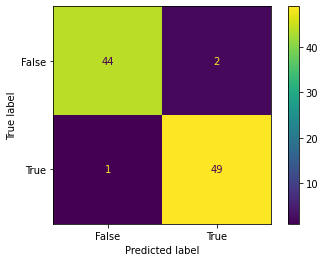

In [13]:
# Build confusion matrix
conf_matrix = metrics.confusion_matrix(train_true_list, train_prediction_list)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()

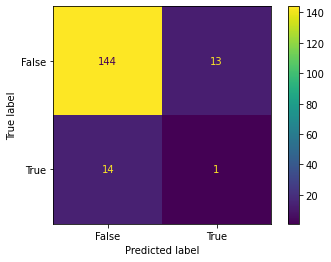

In [14]:
# Build confusion matrix
conf_matrix = metrics.confusion_matrix(test_true_list, test_prediction_list)
df_conf_matrix = pd.DataFrame(conf_matrix/np.sum(conf_matrix) *10, index = [1, 0], columns = [1, 0])
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = [False, True])
cm_display.plot()